There seems to be something wrong with my shooting code for the double pendulum, so I thought I'd try it out on the 2DOF oscillator in Peeters, et al.

In [1]:
import sympy
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.linalg import svd

import matplotlib.pyplot as plt

%matplotlib inline


The equations of motion are $$\begin{align} \ddot x_1 +(2x_1-x_2) + 0.5x_1^3 &= 0\\ \ddot x_2+(2x_2-x_1)&=0\end{align}$$

In [2]:
def zdot(z, t):
    x1, x2, x1dot, x2dot = z
    x1ddot = -0.5*x1**3-(2*x1-x2)
    x2ddot = -(2*x2-x1)
    return (x1dot, x2dot, x1ddot, x2ddot)

In [3]:
def fire(z0, T, returnfull=False):
    t = np.linspace(0, T, 500)
    thetaseries = odeint(zdot, z0, t)
    if returnfull:
        return thetaseries
    else:
        return thetaseries[-1,:]

In [4]:
def measure(theta0, thetaT):
    """Calculate the residual"""
    return thetaT - theta0

def converged(residual, tol):
    """Check convergence to within tol, using the L2 norm"""
    if sum(residual**2) <= tol:
        return True
    else:
        return False, sum(residual**2)

If we just do a standard shooting method, we'll measure the residual, take the Jacobian matrix, and aim for the point where the first order Taylor's series expansion of the residual goes to zero.  We make two modifications to the Jacobian, however: we add the period (so that we can modify it) and we impose the phase condition.  The derivatives are calculated via finite differences.

In [5]:
def augjac(theta0, T):
    """Compute the augmented jacobian matrix and its inverse.
    
    I'm choosing clarity over efficiency here; if it becomes necessary to change that, I'll refactor."""
    
    # get the baseline residual
    final = fire(theta0, T)
    H0 = measure(theta0, final)
    #print "augjac: H0", H0
    aug0 = np.append(H0, 0.0)
    # choose a step size that is 0.01% of the residual
    steps = np.abs(H0*0.0001)
    
    jac = []

    # finite differences
    for idx, step in enumerate(steps):
        #print "augjac: idx, step", idx, step
        thetaidx0 = np.array(theta0)
        #print "augjac: theta0", thetaidx0
        thetaidx0[idx] += step
        #print "augjac: shifted", thetaidx0
        Hidx = measure(thetaidx0, fire(thetaidx0, T))
        #print "augjac: Hidx", Hidx
        #print "augjac: diff", Hidx-H0
        col = (Hidx-H0)/step
        #print "augjac: col", col
        if idx == 2:
            col = np.append(col,[1.0],0)
        else:
            col = np.append(col,[0.0],0)
        jac.append(col)

    # last column is a little different
    dHdT = zdot(final, T)
    jac.append(np.append(np.array(dHdT), 0.0))
    
    #print "AUGJAC: ", np.matrix(np.array(jac)).T
    
    # turn it into a matrix and return the inverse
    return np.matrix(np.array(jac).T).I, np.matrix(aug0).T

The new guess for our vector comes from a matrix multiplication.

In [6]:
def getnewtheta(theta0, T):
    aj, ah = augjac(theta0, T)
    deltas = -aj * ah
    #print "NEWTHETA: ", ah
    #print "deltas: ", deltas
    #print "NEWTHETA: ", aj

#    print "NEWTHETA: ", aj.I*deltas
#    print "NEWTHETA: ", ah

    newtheta = np.append(theta0, T)
#    print "NEWTHETA", newtheta
#    print "NEWTHETA", deltas
    return np.reshape(np.array(deltas),5) + np.reshape(newtheta,5)

Sadly, this doesn't work as well as we'd like. By which I mean it works, but only if you start out really close to the converged values. Also, it has a tendency to shift the energy while looking for the solution.  There are a couple of possible ways to deal with this, but I think the most elegant is to simply search in a basis that automatically preserves the energy.

Originally, I wanted to do this all in one step, but I think it's less unwieldy to do it in separate chunks.  We need to do the following:

* Transform to the energy preserving basis
* solve in that basis
* transform back

Additionally, we could use a diagnostic that measures the energy just to double check that we're conserving energy.  In this system, the total energy is
$$ {\dot x_1^2 + \dot x_2^2 \over 2} + x_1^2 + x_2^2 -x_1x_2 + {x_1^4\over 2}$$ 

In [7]:
def calculate_energy(xvec):
    x1, x2, x1dot, x2dot = xvec
    kinetic = (x1dot**2 + x2dot**2)/2.0
    potential = x1**2 + x2**2 - x1*x2 + x1**4/8.0
    return kinetic + potential

The energy preserving basis

In [8]:
def epbasis(theta0):
# energy preserving basis
    dedx1 = theta0[0]**3/2.0 + 2*theta0[0]-theta0[1]
    dedx2 = 2*theta0[1]-theta0[0]
    dedx1dot = theta0[2]
    dedx2dot = theta0[3]
    basis = []
    basis.append(np.array([0, 1.0, 0, 0]) - np.array([1.0, 0.0, 0.0, 0.0]) * dedx2/dedx1)
    basis.append(np.array([0, 0, 1.0, 0]) - np.array([1.0, 0.0, 0.0, 0.0]) * dedx1dot/dedx1)
    basis.append(np.array([0, 0, 0, 1.0]) - np.array([1.0, 0.0, 0.0, 0.0]) * dedx2dot/dedx1)
    return basis


In [9]:
def newbasisjac(theta0, T):
    """Build the augmented jacobian matrix in an energy preserving basis."""

    # get the baseline residual
    final = fire(theta0, T)
    H0 = measure(theta0, final)
    
    jac = []

    basis = epbasis(final)

    # finite differences
    for idx, vec in enumerate(basis):
        #print "augjac: idx, step", idx, step
        thetaidx0 = np.array(theta0)
        normalized = vec/np.sqrt(sum(vec**2))
        
        #print "augjac: theta0", thetaidx0
        thetaidx0 += normalized*0.01
        #print "augjac: shifted", thetaidx0
        Hidx = measure(thetaidx0, fire(thetaidx0, T))
        #print "augjac: Hidx", Hidx
        #print "augjac: diff", Hidx-H0
        col = (Hidx-H0)/0.01
        jac.append(col)

    # last column is a little different
    dHdT = zdot(final, T)
    jac.append(np.array(dHdT))
    
    #print "AUGJAC: ", np.matrix(np.array(jac)).T
    
    # turn it into a matrix and return the inverse
    #print "jac: ", np.matrix(np.array(jac).T)
    #print "H0: ", np.matrix(H0).T
    #print "basis:", basis
    return np.matrix(np.array(jac).T).I, np.matrix(H0).T, basis
    

In [10]:
def newnewtheta(theta0, T):
    aj, ah, basis = newbasisjac(theta0, T)
    deltas = -aj * ah

#    print "basis: ", basis
#    print "deltas:", deltas
    
    newtheta = theta0
    for idx, vec in enumerate(basis):
        #print "SHAPE:", newtheta.shape, deltas.shape, basis[idx].shape, (deltas*basis[idx]).T.shape
        newtheta += (deltas[idx,0]*basis[idx])

    newtheta = np.append(newtheta, T)
    return newtheta

energy:  0.000238282553574
Converged:  (False, 0.00086219102829970654)
[ -5.05217640e-03  -1.91351352e-02   2.16911768e-02  -7.74187125e-05]
energy:  0.000238281721556


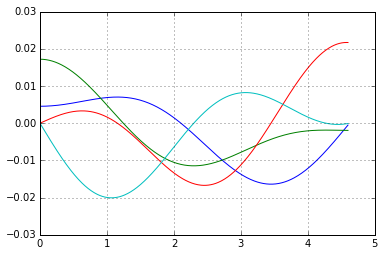

In [12]:
z0 = np.array((4.55, 17.2, 0, 0))*0.001
T = 4.6
print("energy: ", calculate_energy(z0))

ts = fire(z0, T, returnfull=True)
print("Converged: ", converged(z0-ts[-1,:], 1.0e-8))
print(measure(z0, ts[-1,:]))
print("energy: ", calculate_energy(ts[-1,:]))
pltres = plt.plot(np.linspace(0,T,500),ts)
plt.grid()

New guess: 4.6 [ 1.3280703   1.30808273 -0.15084728 -0.02603747] energy  2.13820265173
Converged:  (False, 5.3155650835836354)
[-1.05592593 -0.58597043  1.05146161  1.65881061]


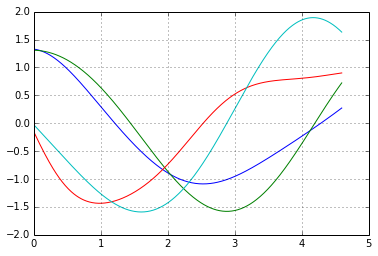

In [48]:
newvec = newnewtheta(z0, T)
newT = newvec[-1]
newtheta = newvec[0:4]
print "New guess:", newT, newtheta, "energy ", calculate_energy(newtheta)
ts = fire(newtheta, newT, returnfull=True)
print "Converged: ", converged(newtheta-ts[-1,:], 1.0e-8)
print measure(newtheta, ts[-1,:])
pltres = plt.plot(np.linspace(0,newT,500),ts)
plt.grid()

New guess: 4.6 [-7.05830769 -4.85494114  3.99004355  1.25242176]
Converged:  (False, 518.39702128046292)
[  5.84995932e+00  -1.85669524e-02   2.20038253e+01  -7.95336565e-02]


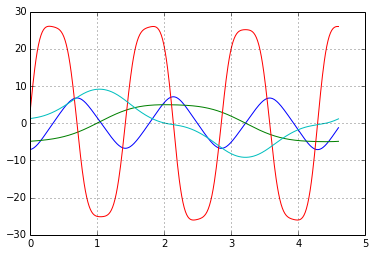

In [40]:
newvec = newnewtheta(newtheta, newT)
newT = newvec[-1]
newtheta = newvec[0:4]
print "New guess:", newT, newtheta
ts = fire(newtheta, newT, returnfull=True)
print "Converged: ", converged(newtheta-ts[-1,:], 1.0e-8)
print measure(newtheta, ts[-1,:])
pltres = plt.plot(np.linspace(0,newT,500),ts)
plt.grid()

basis:  [array([ 1.83241175,  1.        ,  0.        ,  0.        ]), array([-2.71237491,  0.        ,  1.        ,  0.        ]), array([ 0.26296612,  0.        ,  0.        ,  1.        ])]
deltas: [[ 2.93412572]
 [ 3.49759088]
 [-6.02705173]
 [ 7.56000905]]
SHAPE: (4,) (4, 1) (4,) (4, 4)
SHAPE: (4,) (4, 1) (4,) (4, 4)
SHAPE: (4,) (4, 1) (4,) (4, 4)
New guess: 4.83835340779 [-5.67465704  2.28741874  3.34674361 -6.41146613]
Converged:  (False, 169.36689894614545)
[  0.18093676  -2.4529704  -12.77563992   0.31641994]


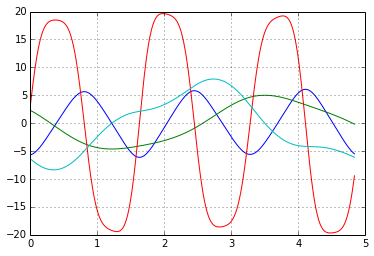

In [33]:
newvec = newnewtheta(newtheta, newT)
newT = newvec[-1]
newtheta = newvec[0:4]
print "New guess:", newT, newtheta
ts = fire(newtheta, newT, returnfull=True)
print "Converged: ", converged(newtheta-ts[-1,:], 1.0e-8)
print measure(newtheta, ts[-1,:])
pltres = plt.plot(np.linspace(0,newT,500),ts)
plt.grid()

New guess: 7.93905115102 [ -1.2253116   -2.77177082   3.34674361  56.35414753]
Converged:  (False, 5021.5017713109246)
[ -2.96697272 -37.46387885 -16.93524897 -57.6398644 ]


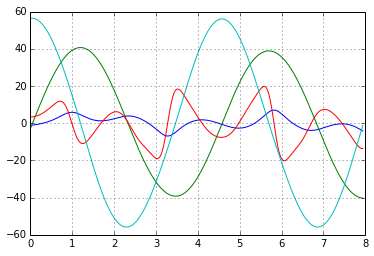

In [34]:
newvec = getnewtheta(newtheta, newT)
newT = newvec[-1]
newtheta = newvec[0:4]
print "New guess:", newT, newtheta
ts = fire(newtheta, newT, returnfull=True)
print "Converged: ", converged(newtheta-ts[-1,:], 1.0e-8)
print measure(newtheta, ts[-1,:])
pltres = plt.plot(np.linspace(0,newT,500),ts)
plt.grid()

Converged:  (False, 10.080223502595967)
[ 1.25253466 -1.65682554  0.83013107  2.25326252]


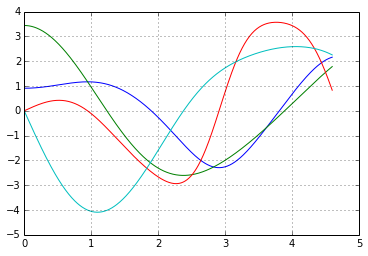

In [137]:
z0 = np.array((4.55, 17.2, 0, 0))*0.2
T = 4.6

ts = fire(z0, T, returnfull=True)
# is it converged?
print "Converged: ", converged(z0-ts[-1,:], 1.0e-8)
# actually, how close is it?
print measure(z0, ts[-1,:])
# and what does that look like, exactly?
pltres = plt.plot(np.linspace(0,T,500),ts)
plt.grid()

New guess: 5.28306480317 [ 1.19606203  0.99769721  0.         -0.3178886 ]
Converged:  (False, 1.1712263628410891)
[-0.49448028  0.31854423  0.42221324  0.8043514 ]


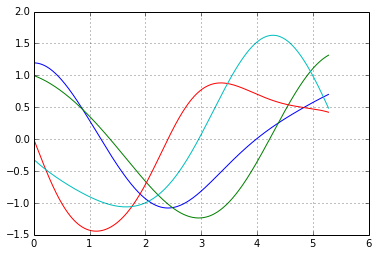

In [136]:
# get a new guess for theta0 and T.
newvec = getnewtheta(z0, T)
# separate into the chunks that fire expects
newT = newvec[-1]
newtheta = newvec[0:4]
print "New guess:", newT, newtheta
ts = fire(newtheta, newT, returnfull=True)
print "Converged: ", converged(newtheta-ts[-1,:], 1.0e-8)
print measure(newtheta, ts[-1,:])
pltres = plt.plot(np.linspace(0,newT,500),ts)
plt.grid()

New guess: 5.15749504765 [-0.10986616 -0.14295563  0.          0.23123152]
Converged:  (False, 0.15644071486886404)
[-0.09458167  0.02695053  0.02949866 -0.38196665]


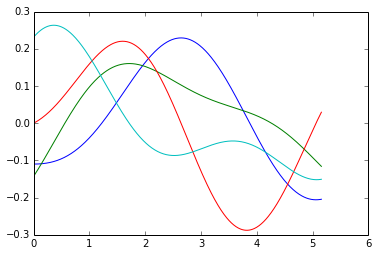

In [131]:
# get a new guess for theta0 and T.
newvec = getnewtheta(newtheta, newT)
# separate into the chunks that fire expects
newT = newvec[-1]
newtheta = newvec[0:4]
print "New guess:", newT, newtheta
ts = fire(newtheta, newT, returnfull=True)
print "Converged: ", converged(newtheta-ts[-1,:], 1.0e-8)
print measure(newtheta, ts[-1,:])
pltres = plt.plot(np.linspace(0,newT,500),ts)

New guess: 5.18711360761 [ 0.00211816  0.00319047  0.         -0.0010268 ]
Converged:  (False, 1.9182816330437709e-05)
[ 0.00016306 -0.00213187  0.0020576   0.00322143]


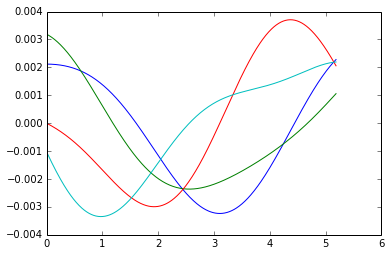

In [132]:
# get a new guess for theta0 and T.
newvec = getnewtheta(newtheta, newT)
# separate into the chunks that fire expects
newT = newvec[-1]
newtheta = newvec[0:4]
print "New guess:", newT, newtheta
ts = fire(newtheta, newT, returnfull=True)
print "Converged: ", converged(newtheta-ts[-1,:], 1.0e-8)
print measure(newtheta, ts[-1,:])
pltres = plt.plot(np.linspace(0,newT,500),ts)

New guess: 5.18610832342 [ -2.30282216e-06  -2.61695606e-06   0.00000000e+00  -1.83416124e-06]
Converged:  True
[  2.17348137e-06   2.19096747e-06  -3.59324936e-06   1.76795350e-07]


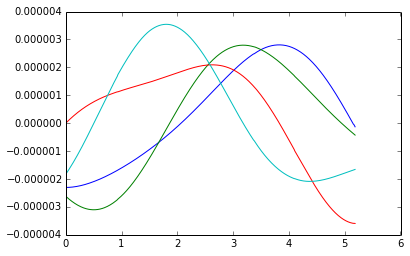

In [133]:
# get a new guess for theta0 and T.
newvec = getnewtheta(newtheta, newT)
# separate into the chunks that fire expects
newT = newvec[-1]
newtheta = newvec[0:4]
print "New guess:", newT, newtheta
ts = fire(newtheta, newT, returnfull=True)
print "Converged: ", converged(newtheta-ts[-1,:], 1.0e-8)
print measure(newtheta, ts[-1,:])
pltres = plt.plot(np.linspace(0,newT,500),ts)

New guess: 4.62523095208 [ 0.30752759  1.25446108  0.         -0.22145795]
Converged:  (False, 3.6072675469249105)
[ 0.25092078 -1.14348369  1.41202084  0.49289807]


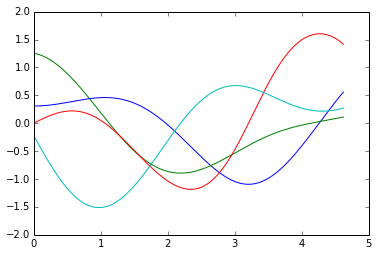

In [93]:
# get a new guess for theta0 and T.
newvec = getnewtheta(newtheta, newT)
# separate into the chunks that fire expects
newT = newvec[-1]
newtheta = newvec[0:4]
print "New guess:", newT, newtheta
ts = fire(newtheta, newT, returnfull=True)
print "Converged: ", converged(newtheta-ts[-1,:], 1.0e-8)
print measure(newtheta, ts[-1,:])
pltres = plt.plot(np.linspace(0,newT,500),ts)

New guess: 4.62796729516 [ 0.28428769  1.17998532  0.         -0.24126097]
Converged:  (False, 3.2515029947341816)
[ 0.24012458 -1.08503507  1.33999111  0.47007012]


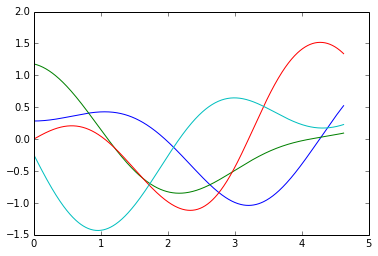

In [94]:
# get a new guess for theta0 and T.
newvec = getnewtheta(newtheta, newT)
# separate into the chunks that fire expects
newT = newvec[-1]
newtheta = newvec[0:4]
print "New guess:", newT, newtheta
ts = fire(newtheta, newT, returnfull=True)
print "Converged: ", converged(newtheta-ts[-1,:], 1.0e-8)
print measure(newtheta, ts[-1,:])
pltres = plt.plot(np.linspace(0,newT,500),ts)

New guess: 4.63031391974 [ 0.26305063  1.11073956  0.         -0.25560615]
Converged:  (False, 2.9312114252028443)
[ 0.22968069 -1.02967228  1.27178148  0.44811279]


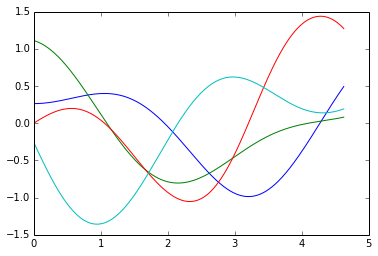

In [95]:
# get a new guess for theta0 and T.
newvec = getnewtheta(newtheta, newT)
# separate into the chunks that fire expects
newT = newvec[-1]
newtheta = newvec[0:4]
print "New guess:", newT, newtheta
ts = fire(newtheta, newT, returnfull=True)
print "Converged: ", converged(newtheta-ts[-1,:], 1.0e-8)
print measure(newtheta, ts[-1,:])
pltres = plt.plot(np.linspace(0,newT,500),ts)

New guess: 4.63233735088 [ 0.24366388  1.04628966  0.         -0.26542193]
Converged:  (False, 2.642789269039489)
[ 0.21958196 -0.97722292  1.20717037  0.42702236]


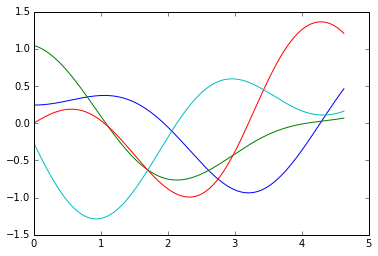

In [96]:
# get a new guess for theta0 and T.
newvec = getnewtheta(newtheta, newT)
# separate into the chunks that fire expects
newT = newvec[-1]
newtheta = newvec[0:4]
print "New guess:", newT, newtheta
ts = fire(newtheta, newT, returnfull=True)
print "Converged: ", converged(newtheta-ts[-1,:], 1.0e-8)
print measure(newtheta, ts[-1,:])
pltres = plt.plot(np.linspace(0,newT,500),ts)

New guess: 4.63409264466 [ 0.22597268  0.98623489  0.         -0.27149579]
Converged:  (False, 2.3830025693004724)
[ 0.20982794 -0.92752313  1.1459475   0.40679231]


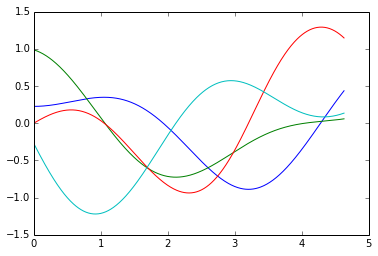

In [97]:
# get a new guess for theta0 and T.
newvec = getnewtheta(newtheta, newT)
# separate into the chunks that fire expects
newT = newvec[-1]
newtheta = newvec[0:4]
print "New guess:", newT, newtheta
ts = fire(newtheta, newT, returnfull=True)
print "Converged: ", converged(newtheta-ts[-1,:], 1.0e-8)
print measure(newtheta, ts[-1,:])
pltres = plt.plot(np.linspace(0,newT,500),ts)

New guess: 4.63562281469 [ 0.20982601  0.93020942  0.         -0.27449218]
Converged:  (False, 2.1489547956504182)
[ 0.20041689 -0.88041906  1.08791715  0.3874099 ]


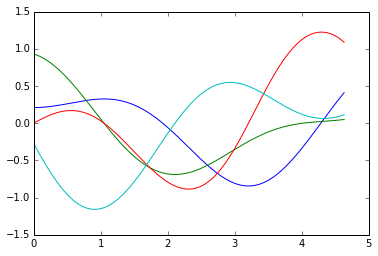

In [98]:
# get a new guess for theta0 and T.
newvec = getnewtheta(newtheta, newT)
# separate into the chunks that fire expects
newT = newvec[-1]
newtheta = newvec[0:4]
print "New guess:", newT, newtheta
ts = fire(newtheta, newT, returnfull=True)
print "Converged: ", converged(newtheta-ts[-1,:], 1.0e-8)
print measure(newtheta, ts[-1,:])
pltres = plt.plot(np.linspace(0,newT,500),ts)

New guess: 4.63696191811 [ 0.19508057  0.87788136  0.         -0.27497053]
Converged:  (False, 1.9380553604873918)
[ 0.19134684 -0.83576655  1.03289869  0.36885813]


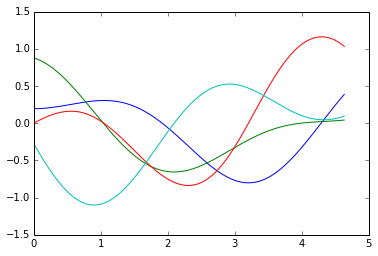

In [99]:
# get a new guess for theta0 and T.
newvec = getnewtheta(newtheta, newT)
# separate into the chunks that fire expects
newT = newvec[-1]
newtheta = newvec[0:4]
print "New guess:", newT, newtheta
ts = fire(newtheta, newT, returnfull=True)
print "Converged: ", converged(newtheta-ts[-1,:], 1.0e-8)
print measure(newtheta, ts[-1,:])
pltres = plt.plot(np.linspace(0,newT,500),ts)

New guess: 4.63813762262 [ 0.18160311  0.82895039  0.         -0.27340097]
Converged:  (False, 1.747982348108561)
[ 0.18261474 -0.79343042  0.98072397  0.35111659]


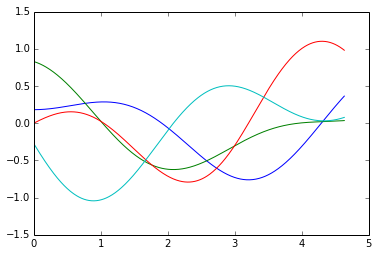

In [100]:
# get a new guess for theta0 and T.
newvec = getnewtheta(newtheta, newT)
# separate into the chunks that fire expects
newT = newvec[-1]
newtheta = newvec[0:4]
print "New guess:", newT, newtheta
ts = fire(newtheta, newT, returnfull=True)
print "Converged: ", converged(newtheta-ts[-1,:], 1.0e-8)
print measure(newtheta, ts[-1,:])
pltres = plt.plot(np.linspace(0,newT,500),ts)

New guess: 4.63917268408 [ 0.16927114  0.7831451   0.         -0.27017839]
Converged:  (False, 1.5766534514337873)
[ 0.17421635 -0.75328391  0.93123634  0.33416216]


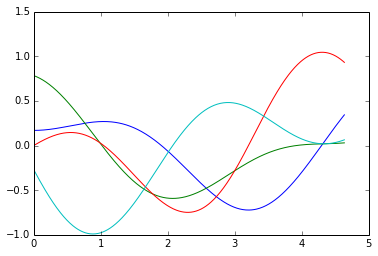

In [101]:
# get a new guess for theta0 and T.
newvec = getnewtheta(newtheta, newT)
# separate into the chunks that fire expects
newT = newvec[-1]
newtheta = newvec[0:4]
print "New guess:", newT, newtheta
ts = fire(newtheta, newT, returnfull=True)
print "Converged: ", converged(newtheta-ts[-1,:], 1.0e-8)
print measure(newtheta, ts[-1,:])
pltres = plt.plot(np.linspace(0,newT,500),ts)

New guess: 4.64008602129 [ 0.157973    0.74022014  0.         -0.26563443]
Converged:  (False, 1.4221998688377717)
[ 0.16614674 -0.71520801  0.88428928  0.3179703 ]


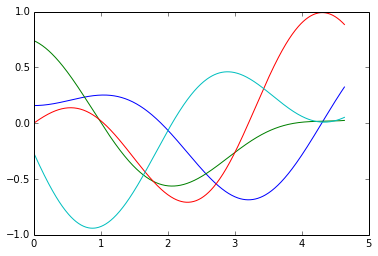

In [102]:
# get a new guess for theta0 and T.
newvec = getnewtheta(newtheta, newT)
# separate into the chunks that fire expects
newT = newvec[-1]
newtheta = newvec[0:4]
print "New guess:", newT, newtheta
ts = fire(newtheta, newT, returnfull=True)
print "Converged: ", converged(newtheta-ts[-1,:], 1.0e-8)
print measure(newtheta, ts[-1,:])
pltres = plt.plot(np.linspace(0,newT,500),ts)

New guess: 4.64714358152 [  3.65774588e-02   1.96011968e-01   3.35337689e-19  -9.51342514e-02]
Converged:  (False, 0.10895531151969953)
[ 0.04777586 -0.19735374  0.24438297  0.08944967]


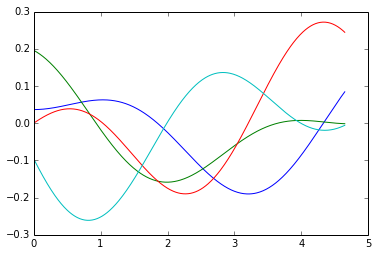

In [127]:
# get a new guess for theta0 and T.
newvec = getnewtheta(newtheta, newT)
# separate into the chunks that fire expects
newT = newvec[-1]
newtheta = newvec[0:4]
print "New guess:", newT, newtheta
ts = fire(newtheta, newT, returnfull=True)
print "Converged: ", converged(newtheta-ts[-1,:], 1.0e-8)
print measure(newtheta, ts[-1,:])
pltres = plt.plot(np.linspace(0,newT,500),ts)

In [16]:
thebasis = epbasis(np.array([1.0, 1.0, 1.0, 1.0]))

In [17]:
thebasis

[array([-0.66666667,  1.        ,  0.        ,  0.        ]),
 array([-0.66666667,  0.        ,  1.        ,  0.        ]),
 array([-0.66666667,  0.        ,  0.        ,  1.        ])]

In [20]:
np.sqrt(sum(thebasis[0]**2))

1.2018504251546631

#### Using scipy.optimize

Let's try using the root finder built in to scipy.optimize instead of trying to roll our own. The function we want to use is `scipy.optimize.root`.

In [5]:
from scipy.optimize import root

In [9]:
def objective(xvec):
    x1, x2, x1dot, x2dot, T = xvec
    res = fire((x1, x2, x1dot, x2dot), T, returnfull=False)
    return np.append(measure((x1, x2, x1dot, x2dot), res), x1dot)


In [10]:
objective((1.0e-6, 1.0e-6, 0, 0, 4.3))

array([-1.09449325, -1.11421178,  0.78997041,  1.26631939,  0.        ])

In [11]:
root(objective, (1.0, 1.0, 0, 0, 4.3), jac=False)

  status: 1
 success: True
     qtf: array([ -1.10563829e-08,   3.50659758e-08,   8.43025120e-09,
         1.52714259e-08,   3.57002344e-09])
    nfev: 15
       r: array([ 1.81596488, -0.60938608,  0.26159099, -0.45770826, -0.21209662,
        1.49580413, -0.35565483,  0.1036569 , -0.98495332,  1.4835429 ,
        0.351909  , -0.73753409,  1.14987604, -0.58497874, -0.53077175])
     fun: array([ -2.03369853e-09,  -7.30865293e-09,   6.97662777e-09,
        -7.16125356e-09,  -1.97511535e-25])
       x: array([ -4.19895637e-09,   8.87297108e-09,  -1.97511535e-25,
         3.25258023e-09,   4.41208269e+00])
 message: 'The solution converged.'
    fjac: array([[ -4.76883633e-01,   5.88239151e-02,  -3.26798213e-01,
          8.13833322e-01,   3.37168401e-17],
       [ -3.50168671e-01,  -6.23124115e-01,   6.89543429e-01,
          1.16739447e-01,   3.45987168e-17],
       [  6.97240487e-03,  -5.51125641e-01,  -4.69983394e-01,
         -1.44802795e-01,   6.74062070e-01],
       [ -7.72296475e